In [1]:
# My Google Drive Mount하기!
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [60]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(
    weights='imagenet'
)

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [97]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

dog_fpath = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/train/dogs/dog.169.jpg'
cat_fpath = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/train/cats/cat.1.jpg'

dog_img = image.load_img(
    dog_fpath,
    target_size=(224, 224)
)

cat_img = image.load_img(
    cat_fpath,
    target_size=(224, 224)
)

dog_arr = image.img_to_array(dog_img)
print('Original Shape:', dog_arr.shape)

dog_arr = np.expand_dims(dog_arr, axis=0)
print('New1 Shape:', dog_arr.shape)

dog_arr = preprocess_input(dog_arr) # preprocess_input: VGG16의 Input에 잘 적용되도록 적절히 변환해주는 것임!
print('New2 Shape:', dog_arr.shape)

cat_arr = image.img_to_array(cat_img)
print('Original Shape:', cat_arr.shape)

cat_arr = np.expand_dims(cat_arr, axis=0)
print('New1 Shape:', cat_arr.shape)

cat_arr = preprocess_input(cat_arr) # preprocess_input: VGG16의 Input에 잘 적용되도록 적절히 변환해주는 것임!
print('New2 Shape:', cat_arr.shape)


Original Shape: (224, 224, 3)
New1 Shape: (1, 224, 224, 3)
New2 Shape: (1, 224, 224, 3)
Original Shape: (224, 224, 3)
New1 Shape: (1, 224, 224, 3)
New2 Shape: (1, 224, 224, 3)


In [98]:
dog_predict = model.predict(dog_arr)
cat_predict = model.predict(cat_arr)

print('Predicted (dog):')
for each in decode_predictions(dog_predict, top=1)[0]:
    print(each)

print('Predicted (cat):')
for each in decode_predictions(cat_predict, top=1)[0]:
    print(each)

Predicted (dog):
('n02087394', 'Rhodesian_ridgeback', 0.35183254)
Predicted (cat):
('n02123045', 'tabby', 0.49306282)


In [99]:
# 가장 높게 추측된 index의 확률을 찾아보자.
print('Dog', dog_predict[0][np.argmax(dog_predict[0])])
print('Cat', cat_predict[0][np.argmax(cat_predict[0])])

Dog 0.35183254
Cat 0.49306282


In [100]:
import tensorflow as tf
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [101]:
heatmap_dog_arr = make_gradcam_heatmap(dog_arr, model, 'block5_conv3')
heatmap_cat_arr = make_gradcam_heatmap(cat_arr, model, 'block5_conv3')

print(heatmap_dog_arr.shape)
print(heatmap_cat_arr.shape)

(14, 14)
(14, 14)


# Dog

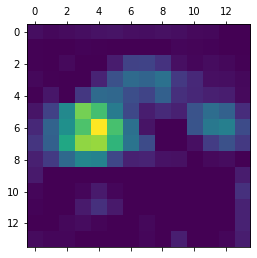

''

In [102]:
import matplotlib.pyplot as plt

heatmap_dog_arr = np.maximum(heatmap_dog_arr, 0)
heatmap_dog_arr = heatmap_dog_arr / np.max(heatmap_dog_arr)
plt.matshow(heatmap_dog_arr)
plt.show()
;

In [44]:
! pip install opencv-python

In [103]:
import cv2
dog_arr = cv2.imread(dog_fpath)

heatmap_dog_arr = cv2.resize(heatmap_dog_arr,
                         (dog_arr.shape[1], dog_arr.shape[0]))

heatmap_dog_arr = np.uint8(255 * heatmap_dog_arr)

heatmap_dog_arr = cv2.applyColorMap(heatmap_dog_arr, cv2.COLORMAP_JET)

SuperImposed_img = heatmap_dog_arr * 0.4 + dog_arr

cv2.imwrite('/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/dog_cam.jpg', 
            SuperImposed_img)

True

# Cat

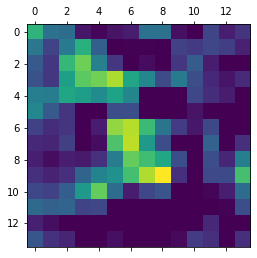

''

In [104]:
import matplotlib.pyplot as plt

heatmap_cat_arr = np.maximum(heatmap_cat_arr, 0)
heatmap_cat_arr = heatmap_cat_arr / np.max(heatmap_cat_arr)
plt.matshow(heatmap_cat_arr)
plt.show()
;

In [105]:
import cv2
cat_arr = cv2.imread(cat_fpath)

heatmap_cat_arr = cv2.resize(heatmap_cat_arr,
                         (cat_arr.shape[1], cat_arr.shape[0]))

heatmap_cat_arr = np.uint8(255 * heatmap_cat_arr)

heatmap_cat_arr = cv2.applyColorMap(heatmap_cat_arr, cv2.COLORMAP_JET)

SuperImposed_img = heatmap_cat_arr * 0.4 + cat_arr

cv2.imwrite('/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/data_Week 09/cat_cam.jpg', 
            SuperImposed_img)

True